In [61]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torcheval.metrics import R2Score

from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths, DATA_DIRECTORY_PATH
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel, TimeSeriesTransformerDecoderModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

### Config


In [62]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"
log_normalized_metric_pct_chg = metric_pct_chg + "_log_normalized_yearly"

In [63]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [64]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [65]:
asset_types_to_train = list(asset_types.keys())
# asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = ["yearly_price_growth"]
core_normalize_columns = []
core_maintain_columns = ["metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [66]:
feature_columns = factor_columns + combined_core_columns + ["land", "condo"]
# extra_prediction_columns = [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
extra_prediction_columns = []

In [67]:
feature_columns

['population_log_normalized_yearly',
 'taxable_income_growth_log_normalized_yearly',
 'taxable_income_per_taxpayer_growth_log_normalized_yearly',
 'net_migration_ratio_log_normalized_yearly',
 'new_dwellings_ratio_log_normalized_yearly',
 'taxpayer_count_growth_log_normalized_yearly',
 'migrations_is_available',
 'taxable_income_is_available',
 'dwellings_is_available',
 'total_tax_is_available',
 'land_yearly_price_growth_log_normalized_yearly',
 'building_yearly_price_growth_log_normalized_yearly',
 'condo_yearly_price_growth_log_normalized_yearly',
 'land_metric_pct_chg_is_available',
 'building_metric_pct_chg_is_available',
 'condo_metric_pct_chg_is_available',
 'land',
 'condo']

### Dataset Prep


In [74]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
df = get_most_active_municipalities(df, count_column=f"population", n=500)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
# df["log_population"] = df["population"].apply(lambda x: np.log(1 + x))
# df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)
df["weight"] = 1

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: train_df[~train_df[f"{asset_type}_{metric_pct_chg}"].isna()]
    .reset_index(drop=True)
    .fillna(0) # only for excess columns
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: eval_df[~eval_df[f"{asset_type}_{metric_pct_chg}"].isna()]
    .reset_index(drop=True)
    .fillna(0) # only for excess columns
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(
        f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}"
    )

land -> Train: (5758, 91), Eval: (1000, 91)
building -> Train: (5701, 91), Eval: (1000, 91)
condo -> Train: (3319, 91), Eval: (588, 91)


In [75]:
# df[df["area_code"] == "13101"][["year", "area_code", "area", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [76]:
feature_columns

['population_log_normalized_yearly',
 'taxable_income_growth_log_normalized_yearly',
 'taxable_income_per_taxpayer_growth_log_normalized_yearly',
 'net_migration_ratio_log_normalized_yearly',
 'new_dwellings_ratio_log_normalized_yearly',
 'taxpayer_count_growth_log_normalized_yearly',
 'migrations_is_available',
 'taxable_income_is_available',
 'dwellings_is_available',
 'total_tax_is_available',
 'land_yearly_price_growth_log_normalized_yearly',
 'building_yearly_price_growth_log_normalized_yearly',
 'condo_yearly_price_growth_log_normalized_yearly',
 'land_metric_pct_chg_is_available',
 'building_metric_pct_chg_is_available',
 'condo_metric_pct_chg_is_available',
 'land',
 'condo']

In [77]:
df["weight"].plot.hist(bins=100)

KeyError: 'weight'

In [72]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]
tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg = (
    f"{asset_type}_{metric}",
    f"{asset_type}_{metric_pct_chg}",
    f"{asset_type}_{log_normalized_metric_pct_chg}",
)

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_robust_price_index,building_robust_price_index_pct_chg,building_robust_price_index_pct_chg_log_normalized_yearly
51,2008,118.948384,0.189484,1.430601
101,2009,86.224605,-0.338315,-1.892999
458,2010,80.533919,-0.322951,-1.425059
1092,2011,86.013352,-0.002450,0.091829
1378,2012,85.337601,0.059648,0.416406
1714,2013,94.431979,0.097876,0.487897
2581,2014,105.058651,0.231094,1.194076
3009,2015,122.670331,0.299034,1.518559
3588,2016,133.886043,0.274393,1.201204
4151,2017,155.137056,0.264666,1.053361


In [73]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_robust_price_index,building_robust_price_index_pct_chg,building_robust_price_index_pct_chg_log_normalized_yearly
167,2021,188.042285,0.031187,0.008555
533,2022,206.957254,0.111035,0.219871


In [15]:
from jre_utils.process import get_window

idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[tmp_normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = get_window(df, area_code, year - years_ahead, 5)

print(f"Target: {target}")
window[factor_columns + combined_core_columns]
# window

Target: 0.0085545615627455


,population_log_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_log_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,building_yearly_price_growth_log_normalized_yearly,building_metric_pct_chg_is_available
9254,1.094578,1.181180,-0.165600,3.536982,1.902188,2.662955,1,1,1,1,0.798517,1.0
11631,1.110245,1.490954,0.894214,4.079340,7.613134,1.466553,1,1,1,1,0.476020,1.0
11953,1.130387,1.515889,0.557545,4.132062,1.530660,1.819093,1,1,1,1,0.623980,1.0
13152,1.151447,1.246128,0.216520,3.300576,4.411286,2.433750,1,1,1,1,0.687682,1.0
14897,1.166419,2.205573,1.541510,3.242182,0.934724,1.958831,1,1,1,1,0.121420,1.0


In [16]:
# window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [17]:
window_length = 5

In [18]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    shift=years_ahead,
    window_length=window_length
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
    shift=years_ahead,
    window_length=window_length
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 14) (1,) [0.40200919] [1.10051432]
1 (1, 14) (1,) [-0.41755824] [2.52548552]
2 (1, 14) (1,) [0.29254141] [3.60947475]
3 (1, 14) (1,) [0.05721351] [4.91899259]
0 torch.Size([5, 14]) torch.Size([1]) tensor([0.4020]) tensor([1.1005])
1 torch.Size([5, 14]) torch.Size([1]) tensor([-0.4176]) tensor([2.5255])
2 torch.Size([5, 14]) torch.Size([1]) tensor([0.2925]) tensor([3.6095])
3 torch.Size([5, 14]) torch.Size([1]) tensor([0.0572]) tensor([4.9190])


In [19]:
BATCH_SIZE = 256

In [20]:
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

In [21]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [22]:
len(train_dataloader)

23

### Building the Transformer Model


In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [52]:
# plot num weights over performance to see if size matters at all (H0: it doesn't matter)
n_features = len(feature_columns)
nlayers = 6
nhead = 6
d_hid = 64 * nhead
d_model = 64 * nhead # embedding dimensions
dropout = 0.2
enc_dropout = 0

# model = TimeSeriesTransformerModel(
#     n_features=n_features,
#     d_model=d_model,
#     nhead=nhead,
#     d_hid=d_hid,
#     nlayers=nlayers,
#     target_size=len(extra_prediction_columns) + 1,
#     dropout=dropout,
#     enc_dropout=enc_dropout,
#     device=device,
# )

model = TimeSeriesTransformerDecoderModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    target_size=len(extra_prediction_columns) + 1,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)

model = model.to(device)

In [53]:
model.eval()

r2_score = R2Score(device=device)
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)
        r2_score.update(
            outputs[:, 0].unsqueeze(1).to(device),
            batch["target"][:, 0].unsqueeze(1).to(device),  # get the first column
        )

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())
        print("R2_score:", r2_score.compute().item())

        break

torch.Size([256, 5, 14]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 0.8590843081474304
R2_score: -1.0914714336395264


In [54]:
learning_rate = 3e-4  # 3e-4
weight_decay = 1e-2  # 1
num_epochs = 100

In [55]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [56]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 14.1824, Eval Loss: 2.4074
Train R^2: -8.1861, Eval R^2: -0.5568
Epoch: 1
Train Loss: 1.4182, Eval Loss: 1.2607
Train R^2: -0.0648, Eval R^2: 0.0580
Epoch: 2
Train Loss: 1.3066, Eval Loss: 1.3430
Train R^2: 0.0051, Eval R^2: 0.0206
Epoch: 3
Train Loss: 1.2901, Eval Loss: 1.3360
Train R^2: 0.0112, Eval R^2: 0.0239
Epoch: 4
Train Loss: 1.2668, Eval Loss: 1.3307
Train R^2: 0.0274, Eval R^2: 0.0258
Epoch: 5
Train Loss: 1.2690, Eval Loss: 1.3044
Train R^2: 0.0258, Eval R^2: 0.0397
Epoch: 6
Train Loss: 1.2594, Eval Loss: 1.3110
Train R^2: 0.0345, Eval R^2: 0.0358
Epoch: 7
Train Loss: 1.2542, Eval Loss: 1.2800
Train R^2: 0.0412, Eval R^2: 0.0543
Epoch: 8
Train Loss: 1.2412, Eval Loss: 1.2467
Train R^2: 0.0478, Eval R^2: 0.0750
Epoch: 9
Train Loss: 1.2285, Eval Loss: 1.2117
Train R^2: 0.0606, Eval R^2: 0.0978
Epoch: 10
Train Loss: 1.2146, Eval Loss: 1.1877
Train R^2: 0.0680, Eval R^2: 0.1149
Epoch: 11
Train Loss: 1.1958, Eval Loss: 1.1758
Train R^2: 0.0844, Eval R^2: 0.124

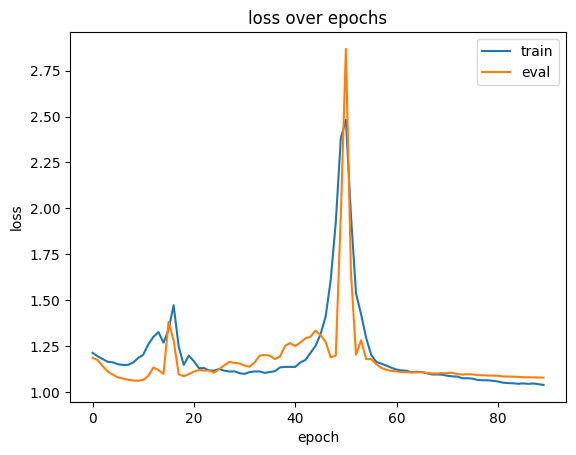

In [59]:
# Plot MSE
plt.plot(train_losses[10:], label="train")
plt.plot(eval_losses[10:], label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

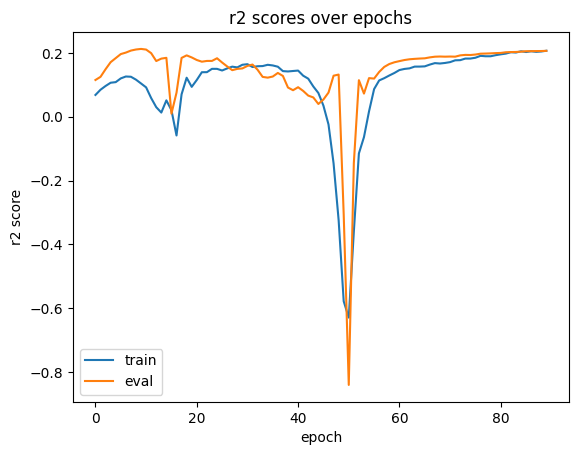

In [60]:
# Plot R2 scores
plt.plot(train_r2_scores[10:], label="train")
plt.plot(eval_r2_scores[10:], label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [110]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 1.0536
Eval R2: 0.2138


In [135]:
years = [2021, 2022]

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(
        model, row["area_code"], row["year"], row["asset_type"]
    ),
    axis=1,
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

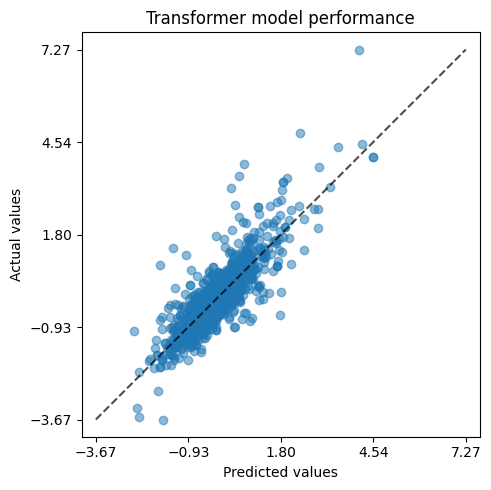

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

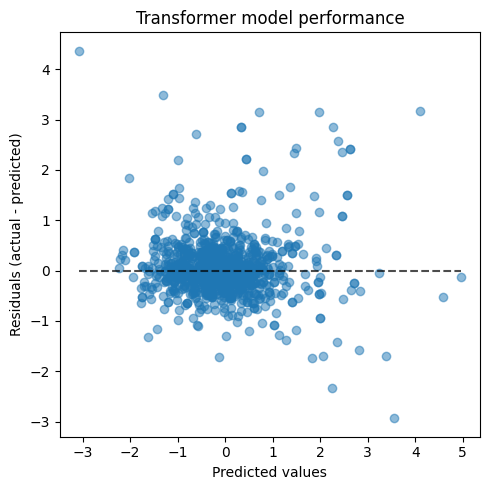

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [221]:
model

TimeSeriesTransformerModel(
  (embedding): Linear(in_features=11, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [319]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 51393
